# Stable diffusion demo

This notebook is adapted from [this repository](https://github.com/woctezuma/stable-diffusion-colab) covered under [MIT License](https://github.com/woctezuma/stable-diffusion-colab/blob/main/LICENSE). It allows to run the Stable Diffusion model *directly*, without going through as service that "hides" the model like openAI.

## Installation

First we need to install a few libraries, notably transformers and diffusers:

In [2]:
%pip install --quiet --upgrade diffusers transformers accelerate invisible_watermark mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00


We need to decide also if we want to use a "refiner" which gives a high-resolution image.

In [3]:
use_refiner = True

## Model loading

Now we load the model which is stored on HuggingFace. Specifically we load a pre-trained version. This can take a while as the whole model with its weights has to be downloaded.

In [4]:
import mediapy as media
import random
import sys
import torch

from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )

if use_refiner:
  refiner = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      text_encoder_2=pipe.text_encoder_2,
      vae=pipe.vae,
      torch_dtype=torch.float16,
      use_safetensors=True,
      variant="fp16",
  )

  refiner = refiner.to("cuda")

  pipe.enable_model_cpu_offload()
else:
  pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
prompt = "a cartoon of a squirell playing violin on a tree under the rain"
seed = random.randint(0, sys.maxsize)

#negative_prompt = "what you don't want to see"
negative_prompt = ""

images = pipe(
    prompt = prompt,
    negative_prompt = negative_prompt,
    output_type = "latent" if use_refiner else "pil",
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

if use_refiner:
  images = refiner(
      prompt = prompt,
      negative_prompt = negative_prompt,
      image = images,
      ).images

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Prompt:	a cartoon of a squirell playing violin on a tree under the rain
Seed:	9029145675535114567


""

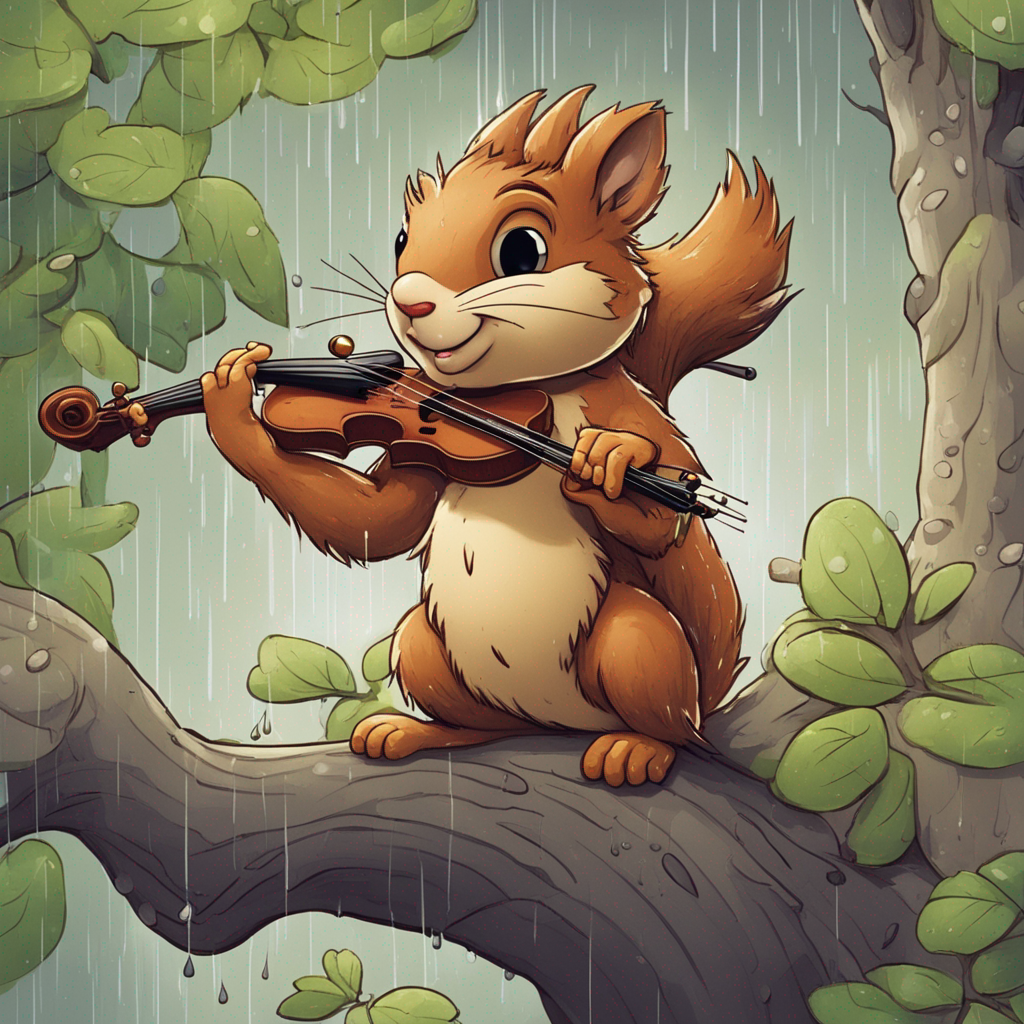

In [28]:
print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)
images[0].save("output1.jpg")